In [105]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.signal import butter, filtfilt, stft
import pywt

from collections import defaultdict


destination = 'collections_20250422_frequency'

# 設定帶通濾波器參數
lowcut = 60_000      # 60 kHz
highcut = 400_000    # 400 kHz
fs = 1_000_000       # 1 MHz

def bandpass_filter(data, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def lowpass_filter(data, cutoff, order=4):
    """
    Low-pass filter for 1D signal.
    :param data: Input signal (1D array)
    :param cutoff: Cutoff frequency (Hz)
    :param order: Filter order
    :return: Filtered signal
    """
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low')
    return filtfilt(b, a, data)

def wavelet_denoise(data, wavelet='db4', threshold_method='soft'):
    maxlev = pywt.dwt_max_level(len(data), pywt.Wavelet(wavelet).dec_len)
    # maxlev = 8
    coeffs = pywt.wavedec(data, wavelet, level=maxlev)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(data)))
    coeffs[1:] = [pywt.threshold(c, value=uthresh, mode=threshold_method) for c in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet)

def plot_spectrum_default(label_list, freq_list, spec_list, enabled_db, enabled_functions, figsize=(7, 5)):
    label_spec_map = defaultdict(list)
    label_freq_map = {}

    for label, freq, spec in zip(label_list, freq_list, spec_list):
        label_spec_map[label].append(spec)
        label_freq_map[label] = freq  # 頻率軸對於同一 label 都一樣

    # 計算統計量
    stat_spec_map = {}
    for label, specs in label_spec_map.items():
        arr = np.vstack(specs)
        stat_spec_map[label] = {
            # 'mean': np.mean(arr, axis=0),
            'min': np.min(arr, axis=0),
            'max': np.max(arr, axis=0),
            'median': np.median(arr, axis=0),
            'q1': np.percentile(arr, 25, axis=0),
            'q3': np.percentile(arr, 75, axis=0),
        }

    # 使用subplot把各統計頻譜分開繪製
    n_labels = len(stat_spec_map)
    n_cols = 2
    n_rows = (n_labels + n_cols - 1) // n_cols
    col_size, row_size = figsize

    plt.figure(figsize=(col_size * n_cols, row_size * n_rows))
    for i, (label, stats) in enumerate(stat_spec_map.items()):
        freq = label_freq_map[label] / 1000  # kHz
        plt.subplot(n_rows, n_cols, i + 1)
        # plt.plot(freq, stats['mean'], label='Mean')
        plt.plot(freq, stats['max'], label='Max')
        plt.plot(freq, stats['q3'], label='Q3')
        plt.plot(freq, stats['median'], label='Median')
        plt.plot(freq, stats['q1'], label='Q1')
        plt.plot(freq, stats['min'], label='Min')
        plt.xlabel('Frequency (kHz)')
        plt.ylabel(f'Energy{enabled_db}')
        plt.title(f'Label: {label}{enabled_functions}')
        plt.legend(fontsize='small')
        plt.tight_layout()
    plt.show()

def plot_spectrum(label_list, freq_list, spec_list, enabled_db, enabled_functions, figsize=(10, 6), presentage = None):

    label_spec_map = defaultdict(list)
    label_freq_map = {}

    for label, freq, spec in zip(label_list, freq_list, spec_list):
        label_spec_map[label].append(spec)
        label_freq_map[label] = freq  # 頻率軸對於同一 label 都一樣

    # 計算統計量
    stat_spec_map = {}
    for label, specs in label_spec_map.items():
        arr = np.vstack(specs)
        stat_spec_map[label] = {
            'data': np.mean(arr, axis=0) if presentage is None
            else np.min(arr, axis=0) if presentage <= 0
            else np.max(arr, axis=0) if presentage >= 100
            else np.percentile(arr, presentage, axis=0),
        }

    plt.figure(figsize=tuple(figsize))
    for label, stats in stat_spec_map.items():
        freq = label_freq_map[label] / 1000  # kHz
        # 可根據需求選擇要畫哪些統計量
        plt.plot(freq, stats['data'], label=f'{label}')
        
    plt.xlabel('Frequency (kHz)')
    plt.ylabel(f'Energy{enabled_db}')
    
    title = 'mean' if presentage is None \
        else 'min' if presentage <= 0 \
        else 'max' if presentage >= 100 \
        else f'{presentage}%'
    
    plt.title(f'Spectrum [{title}]{enabled_functions}')
    
    plt.grid()
    plt.legend(fontsize='small', ncol=2)
    plt.tight_layout()
    plt.show()

def process_data(
    file_path,
    nfft = None,
    enable_db = False,
    enable_wavelet_denoise = False,
    enable_bandpass_filter = False,
    label_transformer = lambda label: label,
    label_skipper = lambda label: False
):
    destination_file_list = []
    # source_file_list = []
    signal_list = []
    label_list = []
    spec_list = []
    freq_list = []
    
    enabled_functions = []
    
    if enable_bandpass_filter:
        enabled_functions.append(f'Filtered ({lowcut / 1000} - {highcut / 1000} kHz)')
        
    if enable_wavelet_denoise:
        enabled_functions.append('Denoised')
        
        
    
    for root, dirs, files in os.walk(file_path):

        label = root.split('\\')[-1].split('captured_data_')[-1].split('_collection')[0]
        label = label.split('_cycle')[0].split('_directly')[0]
        
        label = label_transformer(label)
        
        if label_skipper(label):
            continue
        
        for file in files:
            if file.endswith('.csv'):
                
                label_list.append(label)
                
                destination_file_list.append(os.path.join(destination, root.split('\\')[-1], file))
                
                signal = pd.read_csv(os.path.join(root, file)).to_numpy().flatten()
                signal = signal / 4095
                signal = signal - np.mean(signal)
                
                if enable_bandpass_filter:
                    signal = bandpass_filter(signal)
                    
                if enable_wavelet_denoise:
                    signal = wavelet_denoise(signal)
                
                signal = signal / np.max(np.abs(signal))
                
                signal_list.append(signal)
                
                nfft__ = nfft or len(signal)
                
                freq = np.fft.rfftfreq(n=nfft__, d=1/fs)
                
                freq_list.append(freq)
                
                spec = np.abs(np.fft.rfft(signal, n=nfft__))
                
                if enable_db:
                    spec = 10 * np.log10(spec + 1e-10)
                
                spec_list.append(spec)
                
    return signal_list, label_list, spec_list, freq_list, destination_file_list, ' (' + ', '.join(enabled_functions) + ')' if enabled_functions else '', ' (dB)' if enable_db else ''

In [106]:
def skip_label(label):
    # 這裡可以根據需要定義要跳過的標籤
    return label in ['sand-lagre', 'sand-large']

signal_list, label_list, spec_list, freq_list, _, enabled_functions, enabled_db = process_data(
    file_path = '20250428',
    # file_path = 'collections_20250422',
    
    # nfft=522 * 2 - 1,
    
    enable_db = False,
    enable_wavelet_denoise = False,
    enable_bandpass_filter = False,
    label_transformer = lambda label: label,
    label_skipper = skip_label,
)

In [107]:
# # 隨機選一個 signal_list 的訊號，同時繪製時域與頻域(FFT)圖
# if signal_list:
#     idx = np.random.randint(len(signal_list))
#     sig = signal_list[idx]
#     freq = freq_list[idx]
#     spectrum = spec_list[idx]
#     label = label_list[idx]

#     plt.figure(figsize=(14, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(sig)
#     plt.title(f'signal_list[{label}] - Time Domain')
#     plt.xlabel('Sample')
#     plt.ylabel('Amplitude')

#     plt.subplot(1, 2, 2)
#     plt.plot(freq, spectrum)
#     plt.title(f'signal_list[{label}] - FFT Magnitude Spectrum')
#     plt.xlabel('Frequency (Hz)')
#     plt.ylabel('Magnitude')

#     plt.tight_layout()
#     plt.show()

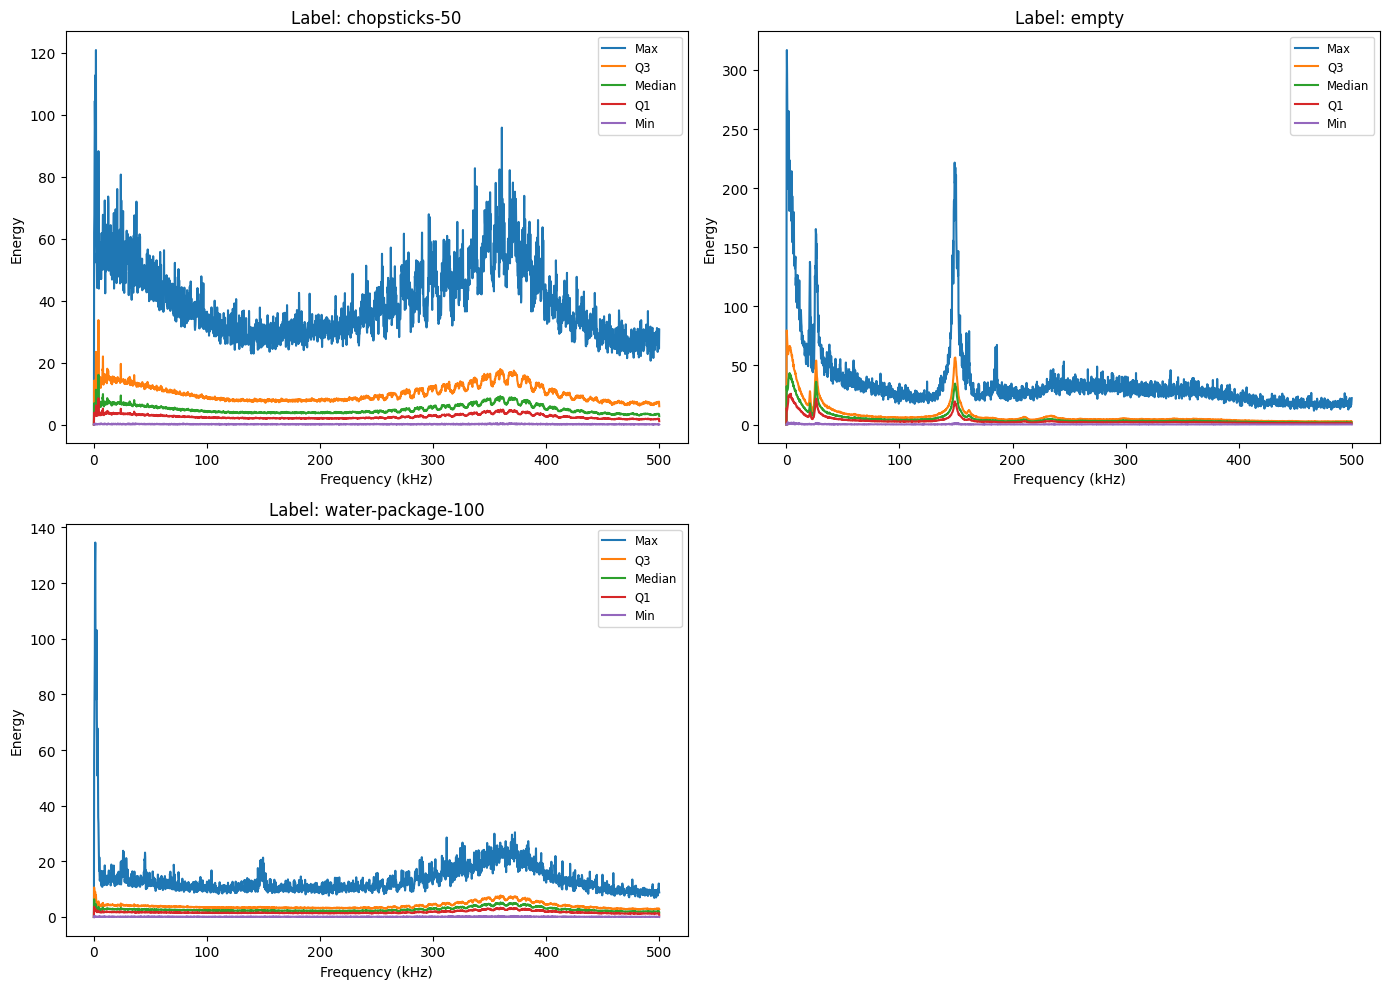

In [108]:
plot_spectrum_default(label_list, freq_list, spec_list, enabled_db, enabled_functions)

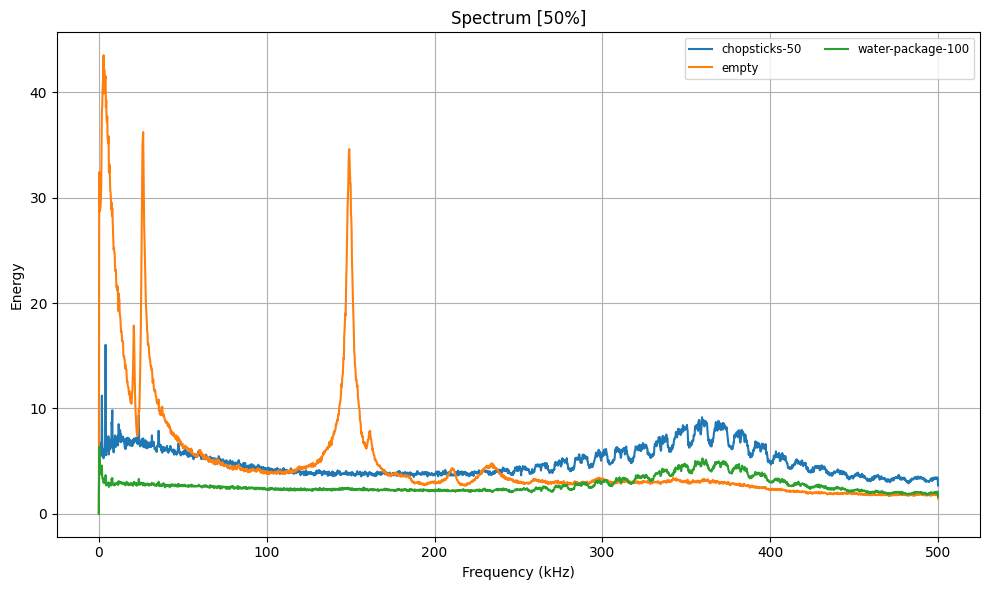

In [109]:
plot_spectrum(
    presentage=50,
    label_list=label_list,
    freq_list=freq_list,
    
    spec_list=spec_list,
    # spec_list=spec_list / np.max(np.abs(spec_list), axis=1, keepdims=True),
    
    enabled_db=enabled_db,
    enabled_functions=enabled_functions,
    # figsize=np.array([10, 6]) * 2,
)

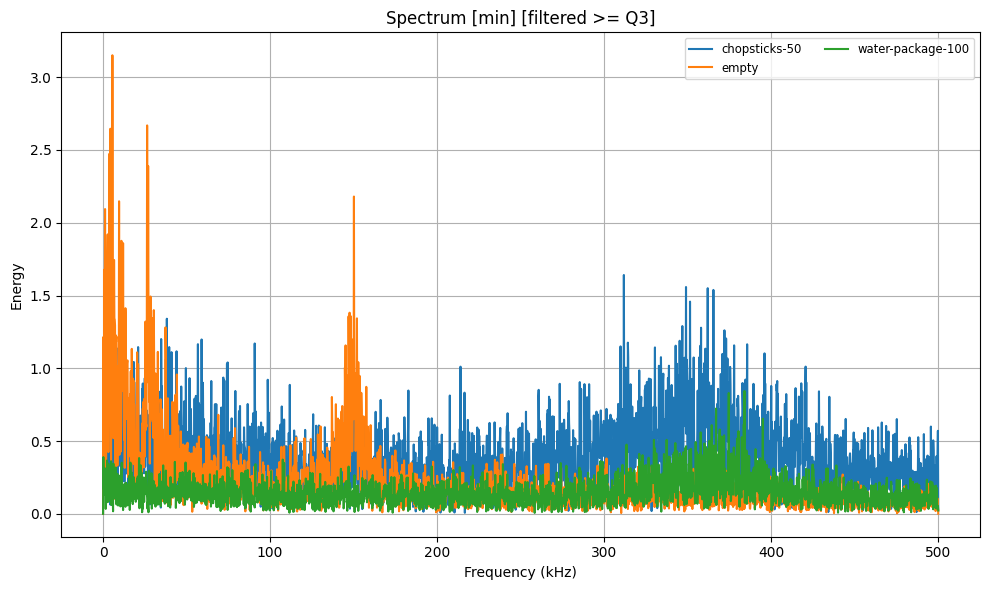

In [110]:
# 篩選Q3以上的資料（以每個樣本頻譜的總能量為例）
import numpy as np
from collections import defaultdict

# 計算每個 label 的樣本總能量
label_energy_map = defaultdict(list)
for label, spec in zip(label_list, spec_list):
    energy = np.sum(spec)
    label_energy_map[label].append(energy)

# 計算每個 label 的 Q3 能量
label_q3_map = {label: np.percentile(energies, 50) for label, energies in label_energy_map.items()}

# 篩選出總能量大於等於 Q3 的樣本
filtered_label_list = []
filtered_freq_list = []
filtered_spec_list = []
filtered_signal_list = []
for label, freq, spec, signal in zip(label_list, freq_list, spec_list, signal_list):
    energy = np.sum(spec)
    if energy >= label_q3_map[label]:
        filtered_label_list.append(label)
        filtered_freq_list.append(freq)
        filtered_spec_list.append(spec)
        filtered_signal_list.append(signal)

# 繪製篩選後的頻譜
plot_spectrum(
    presentage=0,
    label_list=filtered_label_list,
    freq_list=filtered_freq_list,
    spec_list=filtered_spec_list,
    enabled_db=enabled_db,
    enabled_functions=enabled_functions + ' [filtered >= Q3]',
)

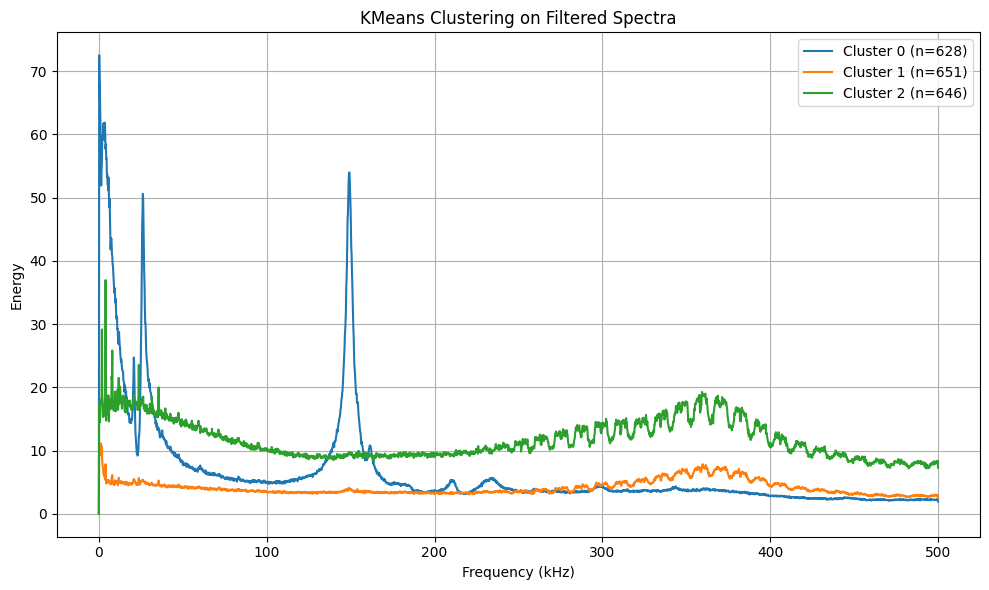

In [111]:
# 使用 KMeans 對篩選後的頻譜進行分群並繪圖
from sklearn.cluster import KMeans

# 將頻譜資料組成矩陣
X = np.vstack(filtered_spec_list)

# 設定分群數量
n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# 將每群的頻譜平均畫出來
plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    idx = np.where(cluster_labels == i)[0]
    if len(idx) == 0:
        continue
    mean_spec = np.mean(X[idx], axis=0)
    freq = filtered_freq_list[0] / 1000  # kHz
    plt.plot(freq, mean_spec, label=f'Cluster {i} (n={len(idx)})')
plt.xlabel('Frequency (kHz)')
plt.ylabel(f'Energy{enabled_db}')
plt.title('KMeans Clustering on Filtered Spectra')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [112]:
# 列印每個 cluster 對應的 label



for i in range(n_clusters):
    idx = np.where(cluster_labels == i)[0]
    # 統計每個 label 在該 cluster 中的數量
    label_counts = {}
    for j in idx:
        label = filtered_label_list[j]
        label_counts[label] = label_counts.get(label, 0) + 1
    labels_in_cluster = sorted(label_counts.items(), key=lambda x: x[0])
    label_count_str = ', '.join([f'{label}:{count}' for label, count in labels_in_cluster])
    print(f'Cluster {i}: [{label_count_str}] (count={len(idx)})')

Cluster 0: [empty:628] (count=628)
Cluster 1: [chopsticks-50:81, empty:25, water-package-100:545] (count=651)
Cluster 2: [chopsticks-50:574, empty:72] (count=646)


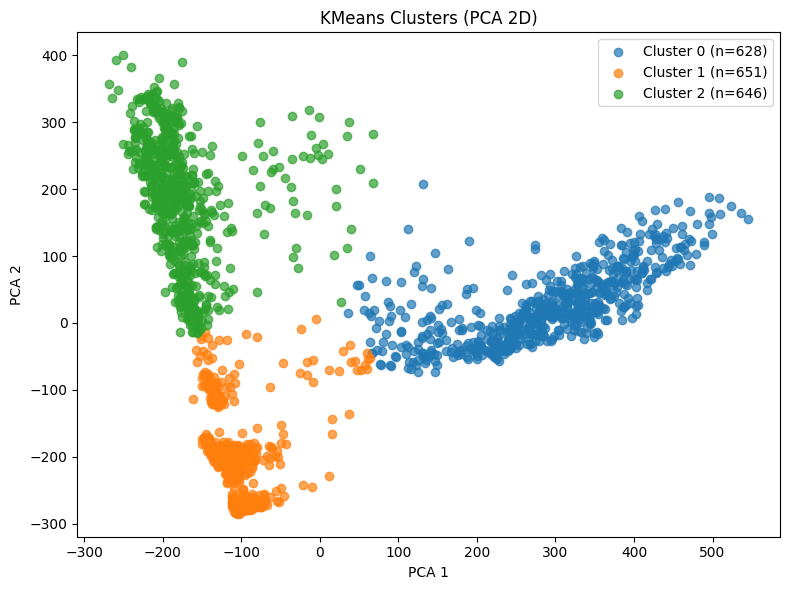

In [113]:
# 使用 PCA 將 KMeans 結果降到 2 維並繪製 2D 散點圖
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    idx = np.where(cluster_labels == i)[0]
    
    
    
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=f'Cluster {i} (n={len(idx)})', alpha=0.7)
# 標註每個點的 label（可選，資料量大時可註解掉）
# for i, label in enumerate(filtered_label_list):
#     plt.text(X_2d[i, 0], X_2d[i, 1], str(label), fontsize=7, alpha=0.5)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('KMeans Clusters (PCA 2D)')
plt.legend()
plt.tight_layout()
plt.show()

In [128]:
# 建立 TensorFlow 分類模型
import tensorflow as tf
from tensorflow.keras import layers, regularizers, models
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def build_model(input_shape=(266,)):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(300, activation='relu', kernel_regularizer=regularizers.l1(0.0001)),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1(0.0001)),
        layers.Dense(3, activation='softmax')
    ])
    return model

# 建立模型
model = build_model()

testttt = np.array(filtered_signal_list)
testttt = testttt / np.max(np.abs(testttt), axis=1, keepdims=True)

filtered_signal_rfft = np.abs(np.fft.rfft(testttt, n=int(266 * 2 - 1), axis=1))

# 建立 X_Train, Y_Train, X_Test, Y_Test，比例為 8:2
from sklearn.model_selection import train_test_split

X = filtered_signal_rfft

# 將 filtered_label_list 轉為 one-hot
label_encoder = LabelEncoder()
Y_int = label_encoder.fit_transform(filtered_label_list)
Y = to_categorical(Y_int)

X_Train, X_Test, Y_Train, Y_Test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y_int
)

# 訓練模型
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 300)            │        80,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         9,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,831 (350.90 KB)

 Trainable params: 89,831 (350.90 KB)

 Non-trainable params: 0 (0.00 B)

In [129]:
history = model.fit(
    X_Train, Y_Train,
    epochs=1000,
    batch_size=32,
    validation_data=(X_Test, Y_Test),
    verbose=2
)

Epoch 1/1000
49/49 - 1s - 20ms/step - accuracy: 0.7630 - loss: 0.9263 - val_accuracy: 0.8468 - val_loss: 0.8289
Epoch 2/1000
49/49 - 0s - 3ms/step - accuracy: 0.9091 - loss: 0.6824 - val_accuracy: 0.8623 - val_loss: 0.7254
Epoch 3/1000
49/49 - 0s - 3ms/step - accuracy: 0.9318 - loss: 0.6001 - val_accuracy: 0.8909 - val_loss: 0.7150
Epoch 4/1000
49/49 - 0s - 3ms/step - accuracy: 0.9474 - loss: 0.5623 - val_accuracy: 0.8909 - val_loss: 0.6809
Epoch 5/1000
49/49 - 0s - 3ms/step - accuracy: 0.9604 - loss: 0.5035 - val_accuracy: 0.8935 - val_loss: 0.6338
Epoch 6/1000
49/49 - 0s - 3ms/step - accuracy: 0.9695 - loss: 0.4686 - val_accuracy: 0.9039 - val_loss: 0.6306
Epoch 7/1000
49/49 - 0s - 3ms/step - accuracy: 0.9675 - loss: 0.4627 - val_accuracy: 0.8494 - val_loss: 0.7512
Epoch 8/1000
49/49 - 0s - 3ms/step - accuracy: 0.9688 - loss: 0.4484 - val_accuracy: 0.9065 - val_loss: 0.6535
Epoch 9/1000
49/49 - 0s - 3ms/step - accuracy: 0.9812 - loss: 0.4028 - val_accuracy: 0.9143 - val_loss: 0.5740


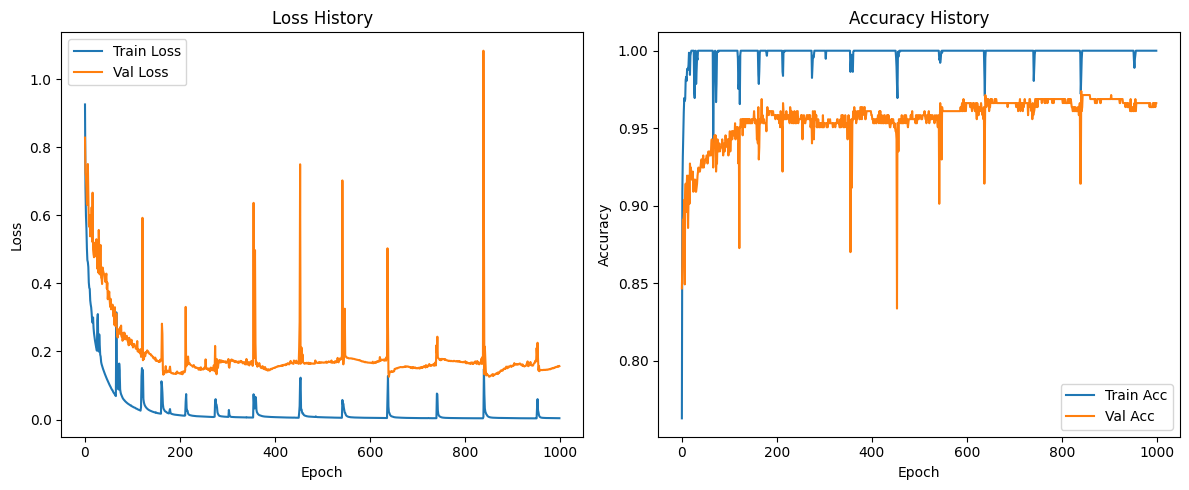

In [130]:
# 繪製訓練過程
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')
plt.tight_layout()
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


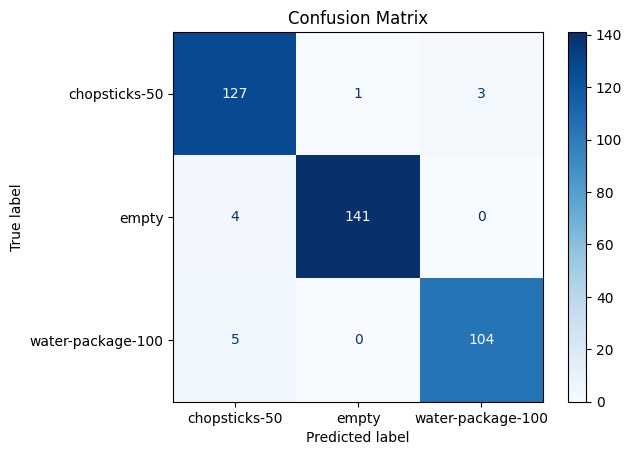

Weighted F1 Score: 0.9664


In [131]:
# 混淆矩陣與 F1 Score
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay

# 預測
Y_pred_prob = model.predict(X_Test)
Y_pred = np.argmax(Y_pred_prob, axis=1)
Y_true = np.argmax(Y_Test, axis=1)

# 混淆矩陣
cm = confusion_matrix(Y_true, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# F1 Score
f1 = f1_score(Y_true, Y_pred, average='weighted')
print(f'Weighted F1 Score: {f1:.4f}')

In [133]:
raw_map = defaultdict(list)
for raw, label in zip(filtered_signal_list, filtered_label_list):
    raw_map[label].append(raw)

destination = 'edge-impulse-raw'

if not os.path.exists(destination):
    os.makedirs(destination)

for label, raws in raw_map.items():
    for i, raw in enumerate(raws):
        raw = raw / np.max(np.abs(raw))
        pd.DataFrame({ 'signal': raw }).to_csv(os.path.join(destination, f'{label}.SR1MHz.{format(i, 'x').zfill(4)}.csv'), index=False)

In [125]:
np.array(filtered_signal_list).shape

(1925, 5000)